System setup

In [1]:
%matplotlib inline

import random
import itertools
import matplotlib.pyplot as plt
import pymc3             as pm
import numpy             as np

from scipy     import stats
from functools import partial
from IPython.core.pylabtools import figsize

Hilfsfunktionen

In [2]:
# Vergleicht zwei Werte.
def compare_conversion(sim, obs):
    return sim == obs

# Erzeugt die Anzahl von Käufern, gegeben eine Konversionsrate und die Anzahl der Besucher.
def simulate_conversion(n, p):
    outcomes = (random.random() < p for _ in range(n))
    return sum(outcomes)

# Gebe die ersten n Werte eines Iterators/Generators zurück.
def take(n, iterable):
    return list(itertools.islice(iterable, n))

# Probabilistic Programming for Data Mining

(am Beispiel A/B Testing)

## Einführung

### Induktive Statistik vs. Bayes'sche Statistik

* Mit Hilfe von A/B Tests wird z. B. im Bereich Webentwicklung versucht Aussagen darüber zu treffen, welches Layout einer Internetseite "besser" ist in Bezug auf eine bestimmte Zielvariable.
* Im Falle von A/B Tests werden in der Induktiven, bzw. Inferenzstatistik Hypothesentests durchgeführt, mit deren Hilfe versucht wird abzuschätzen, ob sich z. B. Mittelwerte signifikant unterscheiden.
* Die Bayes'sche Statistik hingegen versucht in diesem Falle Aussagen darüber zu treffen, mit welcher Wahrscheinlichkeit ein Layout besser als das andere ist ohne dabei Hypothesen zu verwenden.
* Der Bayes'sche Ansatz lässt daher Rückschlüsse in Hinblick darauf zu, wie unsicher man sich bei seinen Schlussfolgerungen ist. Dies ist u. U. ein relevanter Aspekt, weil unsere Schlussfolgerungen immer mit Unsicherheit behaftet sind, da wir in der Regel mit unvollständigen Daten arbeiten müssen.
* Es geht um den Unterschied zwischen Wahrscheinlichkeit als Lanzeit-Häufigkeit (Frequentistisch) und Wahrscheinlichkeit als Vertrauen/Konfidenz (Bayes).

### Grundidee des Bayes'schen Ansatzes

vgl. 
http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb

* Generell wird von einer anfänglichen Wahrscheinlichkeit ausgegangen, die durch Erkenntnisse und Informationen über die Umstände eines Experiments angepasst wird.

* Prior P(A): Ausgangsüberzeugung über den Eintritt eines Ereignisses.

* Posterior (A|E): Angepasste Überzeugung über den Eintritt eines Ereignisses, nachdem man bestimmte Beobachtungen gemacht hat.

* Das Bayes'sche Theorem bestimmt, wie eine Überzeugung aufgrund neuer Informationen angepasst wird: P(A|E) ∝ P(E|A)P(A), d. h. die a-posteriori Überzeugung verhält sich proportional zum Produkt aus a-priori Überzeugung und dem sogenannten Likelihood. Die Likelihood gibt an, wie wahrscheinlich es ist, die beoachteten Daten zu erhalten, falls eine bestimmte Überzeugung wahr ist.

## Beispiel A/B Test im eCommerce

* Ausgangspunkt: Layout A hat 100 Besucher und 4 Käufer. Nach der Maximum Likelihood Methode würde sich daraus eine Konversionsrate von 4% ergeben. Wir haben keine weiteren Informationen über die Konversionsrate dieses Layouts.

* Wir wissen, dass Layout B eine Konversionsrate zwischen 4% und 8% hat. Zuletzt haben wir bei 40 Besuchern 5 Käufer gemessen.

* Das Problem dieses frequentistischen Ansatzes ist, dass in "4%" weder die Information über die Anzahl der Daten enthalten ist, noch wie 'sicher' diese Angabe ist.

### 'from scratch'-Ansatz

vgl.
https://www.safaribooksonline.com/oriole/probabilistic-programming-from-scratch-1-a-b-testing-with-approximate-bayesian-computation


Prinzipielle Idee:
1. Erzeuge einen 'Versuchswert' für die vorherzusagende Größe.
2. Simuliere die Daten, gegeben diesen Versuchswert.
3. Wiederhole 1 und 2 solange, bis eine ausreichend große Zahl an Versuchswerten vorhanden ist, die 'funktionieren'.

Um einen Versuchswert zu erzeugen, definieren wir Funktionen, die von entsprechenden, a-priori Verteilungen sampeln können.

In [3]:
# Gleichverteilung; vgl. Layout A.
def prior_sampler_uniform():
    while True:
        yield random.random()
        
# Normalverteilung; vgl. Layout B.
def prior_sampler_normal(mu, sigma):
    while True:
        x = random.normalvariate(mu, sigma)
        if 0 <= x <= 1:
            yield x

Erzeuge ein Sample aus der a-posteriori Verteilung, indem das angenommene Datengenerationsschema (i. e. die a-priori Verteilung) mit den vorhandenen Daten kombiniert (hier: verglichen) wird.

In [4]:
# abc = "Approximate Bayesian Computation"-Algorithmus.
def abc(data, prior_sampler, simulate, compare):
    for p in prior_sampler:
        if compare(simulate(p), data):
            yield p

Sample von der a-posteriori Verteilungen der beiden Tests.

In [5]:
posterior_sampler_A = abc(
    data=4,  # 4 Käufer
    prior_sampler=prior_sampler_uniform(),
    simulate=partial(simulate_conversion, 100), # Anzahl der Besucher
    compare=compare_conversion)

In [6]:
posterior_sampler_B = abc(
    data=5,
    prior_sampler=prior_sampler_normal(0.06, 0.02),
    simulate=partial(simulate_conversion, 40),
    compare=compare_conversion)

In [7]:
nsamples = 50000
samples_A = take(nsamples, posterior_sampler_A)
samples_B = take(nsamples, posterior_sampler_B)

Visualisiere die a-priori Verteilungen.

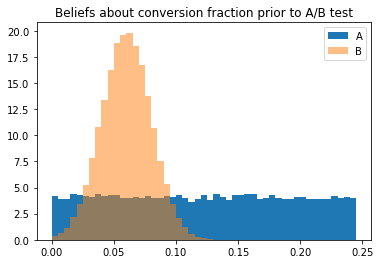

In [8]:
abbins = [i/200.0 for i in range(50)]  # 50 bins between 0 and 0.25
trial_as = take(100000, prior_sampler_uniform())
trial_bs = take(100000, prior_sampler_normal(0.06, 0.02))

plt.hist(trial_as, bins=abbins, label='A', normed=True)
plt.hist(trial_bs, bins=abbins, label='B', alpha=0.5, normed=True)
plt.title('Beliefs about conversion fraction prior to A/B test')
plt.legend();

Visualisiere die a-posteriori Verteilungen.

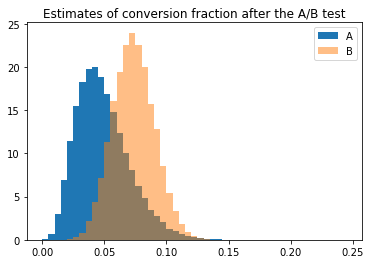

In [9]:
plt.hist(samples_A, bins=abbins, label='A', normed=True)
plt.hist(samples_B, bins=abbins, label='B', alpha=0.5, normed=True)
plt.title('Estimates of conversion fraction after the A/B test')
plt.legend();

Evaluiere das Ergbnis des A/B Tests.

In [10]:
b_better = [b > a for a, b in zip(samples_A, samples_B)]
print(sum(b_better)/len(samples_A))

0.82578


Dies liest sich nun folgendermaßen: Mit einer Wahrscheinlichkeit von 82% ist Layout B besser als Layout A. Diese Information erweitert die initiale Aussage das Layout B (5%) besser ist als Layout A (4%).